In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import torch
import torchvision
import matplotlib.pyplot as plt
import time
import copy
import random

import os
import shutil
from tqdm import tqdm
import zipfile

In [3]:
data_root = '/kaggle/input/architectural-heritage-elements-image64-dataset'

train_dir = 'train'
test_dir = 'test'
val_dir = 'val'

class_names = ['altar', 'apse', 'bell_tower', 'column','dome(inner)','dome(outer)',\
               'flying_buttress','gargoyle','stained_glass','vault']

for dir_name in [train_dir, test_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir_train = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir_train))):
        if i % 10 != 0:
            dest_dir = os.path.join(train_dir, class_name)
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir_train, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 1097/1097 [00:08<00:00, 130.12it/s]


In [4]:
for class_name in class_names:
    source_dir_test = os.path.join(data_root, 'test', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir_test))):
        dest_dir = os.path.join(test_dir, class_name)
        shutil.copy(os.path.join(source_dir_test, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 163/163 [00:01<00:00, 143.86it/s]


In [5]:
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 128
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [6]:
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dataset = torchvision.datasets.ImageFolder(test_dir, test_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [7]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            all_labels = []
            all_preds = []

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()

                        # Gradient clipping
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

                all_labels += labels.tolist()
                all_preds += preds_class.tolist()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

            if phase == 'val':
                print(classification_report(all_labels, all_preds))
                print(confusion_matrix(all_labels, all_preds))

    return model


resnet from scartch

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [9]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [11]:
num_classes = 10
batch_size = 16
learning_rate = 0.01

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss = torch.nn.CrossEntropyLoss()
model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)
optimizer = torch.optim.Adam(model.parameters(), amsgrad = True, lr=1.0e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

#Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)  

# Train the model
train_model(model=model, loss=loss, optimizer=optimizer, scheduler=scheduler, num_epochs=50);
# total_step = len(train_loader)

Epoch 0/49:


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
100%|██████████| 71/71 [00:26<00:00,  2.67it/s]

train Loss: 1.9023 Acc: 0.3019



100%|██████████| 8/8 [00:01<00:00,  4.61it/s]

val Loss: 1.5599 Acc: 0.3759
              precision    recall  f1-score   support

           0       0.45      0.75      0.56        83
           1       0.00      0.00      0.00        51
           2       0.28      0.07      0.11       106
           3       0.28      0.77      0.41       192
           4       0.00      0.00      0.00        59
           5       0.67      0.15      0.25       118
           6       0.00      0.00      0.00        41
           7       0.30      0.17      0.21       157
           8       0.85      0.82      0.84       100
           9       0.35      0.36      0.36       110

    accuracy                           0.38      1017
   macro avg       0.32      0.31      0.27      1017
weighted avg       0.36      0.38      0.32      1017

[[ 62   0   0   9   0   0   0   1   0  11]
 [  2   0   0  28   0   1   0  16   0   4]
 [  1   0   7  84   0   5   0   8   1   0]
 [ 13   0   2 147   0   1   0   8   8  13]
 [ 12   0   0  12   0   0   0   5   0  3


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 71/71 [00:25<00:00,  2.81it/s]

train Loss: 1.4682 Acc: 0.4836



100%|██████████| 8/8 [00:01<00:00,  4.71it/s]

val Loss: 1.2753 Acc: 0.5457
              precision    recall  f1-score   support

           0       0.47      0.82      0.59        83
           1       0.25      0.59      0.36        51
           2       0.38      0.42      0.40       106
           3       0.79      0.48      0.60       192
           4       0.68      0.22      0.33        59
           5       0.74      0.69      0.72       118
           6       0.50      0.05      0.09        41
           7       0.64      0.58      0.61       157
           8       0.55      0.96      0.70       100
           9       0.53      0.34      0.41       110

    accuracy                           0.55      1017
   macro avg       0.55      0.52      0.48      1017
weighted avg       0.60      0.55      0.53      1017

[[68  2  1  1  1  0  0  0  6  4]
 [ 4 30  5  2  0  4  0  5  1  0]
 [ 2 17 45 11  0 12  0 14  5  0]
 [12 18 29 92  1  6  1  4 25  4]
 [ 7  1  0  1 13  0  0 12  5 20]
 [ 0 11 15  0  0 82  1  6  2  1]
 [ 1 17  9  0 


100%|██████████| 71/71 [00:25<00:00,  2.81it/s]

train Loss: 1.2921 Acc: 0.5471



100%|██████████| 8/8 [00:01<00:00,  4.74it/s]

val Loss: 1.2392 Acc: 0.5556
              precision    recall  f1-score   support

           0       0.72      0.51      0.60        83
           1       0.62      0.16      0.25        51
           2       0.37      0.66      0.47       106
           3       0.73      0.73      0.73       192
           4       0.82      0.46      0.59        59
           5       0.76      0.35      0.48       118
           6       0.67      0.05      0.09        41
           7       0.39      0.85      0.54       157
           8       0.92      0.81      0.86       100
           9       0.50      0.21      0.29       110

    accuracy                           0.56      1017
   macro avg       0.65      0.48      0.49      1017
weighted avg       0.63      0.56      0.54      1017

[[ 42   1   2  10   1   0   1  15   1  10]
 [  0   8  17   7   1   4   0  13   0   1]
 [  0   2  70   8   0   2   0  23   1   0]
 [  3   0  20 140   0   1   0  25   0   3]
 [  1   0   0   2  27   2   0  20   0   


100%|██████████| 71/71 [00:25<00:00,  2.81it/s]

train Loss: 1.1617 Acc: 0.5993



100%|██████████| 8/8 [00:01<00:00,  4.38it/s]

val Loss: 0.9978 Acc: 0.6533
              precision    recall  f1-score   support

           0       0.58      0.78      0.66        83
           1       0.49      0.57      0.53        51
           2       0.76      0.21      0.33       106
           3       0.89      0.66      0.76       192
           4       0.71      0.71      0.71        59
           5       0.65      0.76      0.70       118
           6       0.38      0.54      0.44        41
           7       0.57      0.83      0.68       157
           8       0.76      0.99      0.86       100
           9       0.65      0.36      0.47       110

    accuracy                           0.65      1017
   macro avg       0.64      0.64      0.61      1017
weighted avg       0.68      0.65      0.64      1017

[[ 65   1   1   1   3   2   0   0   4   6]
 [  1  29   1   3   0   5   8   4   0   0]
 [  2  13  22   3   0  25   4  36   0   1]
 [  9   8   4 126   0   6   7  22   8   2]
 [  0   0   0   0  42   0   1   6   3   


100%|██████████| 71/71 [00:25<00:00,  2.81it/s]

train Loss: 1.0719 Acc: 0.6320



100%|██████████| 8/8 [00:01<00:00,  4.73it/s]

val Loss: 1.0198 Acc: 0.6529
              precision    recall  f1-score   support

           0       0.47      0.83      0.60        83
           1       0.64      0.41      0.50        51
           2       0.45      0.60      0.52       106
           3       0.86      0.65      0.74       192
           4       0.71      0.69      0.70        59
           5       0.65      0.86      0.74       118
           6       0.47      0.20      0.28        41
           7       0.65      0.83      0.73       157
           8       0.94      0.90      0.92       100
           9       0.77      0.15      0.26       110

    accuracy                           0.66      1017
   macro avg       0.66      0.61      0.60      1017
weighted avg       0.69      0.66      0.64      1017

[[ 69   0   7   0   2   1   0   0   1   3]
 [  0  21   9   4   0  10   1   6   0   0]
 [  1   4  64   4   0  18   1  14   0   0]
 [ 21   4  27 124   0   3   1  11   1   0]
 [  2   1   1   1  41   3   0   7   2   


100%|██████████| 71/71 [00:25<00:00,  2.80it/s]

train Loss: 0.9919 Acc: 0.6637



100%|██████████| 8/8 [00:01<00:00,  5.11it/s]

val Loss: 1.0482 Acc: 0.6374
              precision    recall  f1-score   support

           0       0.51      0.83      0.63        83
           1       0.52      0.47      0.49        51
           2       0.59      0.65      0.62       106
           3       0.94      0.35      0.52       192
           4       0.78      0.66      0.72        59
           5       0.88      0.56      0.68       118
           6       0.22      0.80      0.35        41
           7       0.79      0.71      0.75       157
           8       0.81      0.98      0.89       100
           9       0.63      0.65      0.64       110

    accuracy                           0.64      1017
   macro avg       0.67      0.67      0.63      1017
weighted avg       0.73      0.64      0.64      1017

[[ 69   0   0   0   2   0   1   0   2   9]
 [  2  24   2   2   1   0  19   1   0   0]
 [  4   6  69   1   0   7  13   3   2   1]
 [ 35   9  22  68   0   1  23   7   9  18]
 [  0   1   0   0  39   0   3   6   2   


100%|██████████| 71/71 [00:25<00:00,  2.81it/s]

train Loss: 0.9416 Acc: 0.6834



100%|██████████| 8/8 [00:01<00:00,  4.85it/s]

val Loss: 0.8542 Acc: 0.6953
              precision    recall  f1-score   support

           0       0.97      0.43      0.60        83
           1       0.87      0.39      0.54        51
           2       0.85      0.27      0.41       106
           3       0.79      0.79      0.79       192
           4       0.72      0.58      0.64        59
           5       0.84      0.82      0.83       118
           6       0.40      0.44      0.42        41
           7       0.57      0.89      0.69       157
           8       0.91      0.89      0.90       100
           9       0.51      0.85      0.64       110

    accuracy                           0.69      1017
   macro avg       0.74      0.63      0.65      1017
weighted avg       0.75      0.69      0.68      1017

[[ 36   0   0   1   2   0   0   4   2  38]
 [  0  20   1   7   2   4  11   6   0   0]
 [  0   1  29  18   0  10   1  46   0   1]
 [  0   1   1 151   0   1   5  14   3  16]
 [  0   0   0   1  34   0   0   4   0  2


100%|██████████| 71/71 [00:25<00:00,  2.81it/s]

train Loss: 0.8780 Acc: 0.7064



100%|██████████| 8/8 [00:01<00:00,  5.02it/s]

val Loss: 0.7118 Acc: 0.7446
              precision    recall  f1-score   support

           0       0.65      0.86      0.74        83
           1       0.41      0.76      0.53        51
           2       0.58      0.57      0.57       106
           3       0.86      0.72      0.79       192
           4       0.77      0.90      0.83        59
           5       0.79      0.86      0.82       118
           6       0.59      0.54      0.56        41
           7       0.87      0.73      0.79       157
           8       0.90      0.92      0.91       100
           9       0.83      0.61      0.70       110

    accuracy                           0.75      1017
   macro avg       0.73      0.75      0.73      1017
weighted avg       0.77      0.75      0.75      1017

[[ 71   2   0   0   2   1   0   0   2   5]
 [  1  39   0   3   2   4   1   1   0   0]
 [  1  17  60   8   0  17   1   2   0   0]
 [  8  18  12 139   2   2   2   5   2   2]
 [  0   2   0   0  53   1   0   1   0   


100%|██████████| 71/71 [00:25<00:00,  2.81it/s]

train Loss: 0.8350 Acc: 0.7161



100%|██████████| 8/8 [00:01<00:00,  4.71it/s]

val Loss: 0.6268 Acc: 0.7852
              precision    recall  f1-score   support

           0       0.76      0.83      0.79        83
           1       0.65      0.73      0.69        51
           2       0.57      0.73      0.64       106
           3       0.88      0.80      0.84       192
           4       0.83      0.83      0.83        59
           5       0.83      0.81      0.82       118
           6       0.67      0.54      0.59        41
           7       0.80      0.78      0.79       157
           8       0.91      0.98      0.94       100
           9       0.83      0.70      0.76       110

    accuracy                           0.79      1017
   macro avg       0.77      0.77      0.77      1017
weighted avg       0.79      0.79      0.79      1017

[[ 69   0   3   0   2   2   0   0   2   5]
 [  0  37   3   3   1   4   1   2   0   0]
 [  0   6  77   7   0  10   3   3   0   0]
 [  6   5  12 153   0   1   1   6   4   4]
 [  0   2   0   0  49   1   0   4   0   


100%|██████████| 71/71 [00:25<00:00,  2.81it/s]

train Loss: 0.8123 Acc: 0.7259



100%|██████████| 8/8 [00:01<00:00,  5.11it/s]

val Loss: 0.8340 Acc: 0.7144
              precision    recall  f1-score   support

           0       0.60      0.96      0.74        83
           1       0.35      0.84      0.49        51
           2       0.58      0.62      0.60       106
           3       0.91      0.54      0.68       192
           4       0.85      0.78      0.81        59
           5       0.86      0.74      0.79       118
           6       0.38      0.20      0.26        41
           7       0.83      0.73      0.78       157
           8       0.92      0.93      0.93       100
           9       0.72      0.78      0.75       110

    accuracy                           0.71      1017
   macro avg       0.70      0.71      0.68      1017
weighted avg       0.76      0.71      0.72      1017

[[ 80   0   0   0   0   0   0   0   0   3]
 [  1  43   2   2   2   1   0   0   0   0]
 [  2  20  66   3   0   6   1   7   0   1]
 [ 22  22  20 103   0   2   1   8   6   8]
 [  2   0   0   0  46   0   0   2   0   


100%|██████████| 71/71 [00:25<00:00,  2.82it/s]

train Loss: 0.7681 Acc: 0.7427



100%|██████████| 8/8 [00:01<00:00,  4.62it/s]

val Loss: 0.7960 Acc: 0.7209
              precision    recall  f1-score   support

           0       0.60      0.76      0.67        83
           1       0.76      0.49      0.60        51
           2       0.76      0.47      0.58       106
           3       0.75      0.82      0.78       192
           4       0.80      0.83      0.82        59
           5       0.72      0.91      0.80       118
           6       0.47      0.51      0.49        41
           7       0.67      0.88      0.76       157
           8       1.00      0.58      0.73       100
           9       0.78      0.59      0.67       110

    accuracy                           0.72      1017
   macro avg       0.73      0.68      0.69      1017
weighted avg       0.74      0.72      0.72      1017

[[ 63   2   1   6   0   2   2   1   0   6]
 [  0  25   3   7   1   7   3   5   0   0]
 [  2   3  50   9   1  20   2  19   0   0]
 [  5   2   1 158   0   7   1  14   0   4]
 [  1   0   0   0  49   0   0   3   0   


100%|██████████| 71/71 [00:25<00:00,  2.82it/s]

train Loss: 0.7370 Acc: 0.7502



100%|██████████| 8/8 [00:01<00:00,  4.79it/s]

val Loss: 0.5859 Acc: 0.7929
              precision    recall  f1-score   support

           0       0.85      0.76      0.80        83
           1       0.57      0.67      0.61        51
           2       0.72      0.60      0.66       106
           3       0.83      0.90      0.86       192
           4       0.78      0.88      0.83        59
           5       0.86      0.76      0.81       118
           6       0.43      0.66      0.52        41
           7       0.91      0.74      0.82       157
           8       0.89      0.96      0.92       100
           9       0.79      0.84      0.81       110

    accuracy                           0.79      1017
   macro avg       0.76      0.78      0.76      1017
weighted avg       0.80      0.79      0.79      1017

[[ 63   0   0   3   2   0   1   0   1  13]
 [  0  34   1   6   1   3   4   2   0   0]
 [  1  16  64   6   0  10   4   3   2   0]
 [  5   4   0 172   1   1   2   1   4   2]
 [  0   0   0   0  52   0   2   1   0   


100%|██████████| 71/71 [00:25<00:00,  2.80it/s]

train Loss: 0.6976 Acc: 0.7634



100%|██████████| 8/8 [00:01<00:00,  4.71it/s]

val Loss: 0.5971 Acc: 0.7851
              precision    recall  f1-score   support

           0       0.56      0.94      0.70        83
           1       0.79      0.43      0.56        51
           2       0.81      0.53      0.64       106
           3       0.82      0.88      0.85       192
           4       0.96      0.85      0.90        59
           5       0.72      0.92      0.81       118
           6       0.65      0.41      0.51        41
           7       0.81      0.85      0.83       157
           8       0.99      0.91      0.95       100
           9       0.81      0.67      0.74       110

    accuracy                           0.79      1017
   macro avg       0.79      0.74      0.75      1017
weighted avg       0.80      0.79      0.78      1017

[[ 78   0   0   1   0   2   0   0   0   2]
 [  2  22   2   8   1  12   2   2   0   0]
 [  3   4  56  13   0  21   1   8   0   0]
 [ 11   0   1 169   1   3   0   3   0   4]
 [  2   0   0   0  50   0   0   1   1   


100%|██████████| 71/71 [00:25<00:00,  2.81it/s]

train Loss: 0.6887 Acc: 0.7655



100%|██████████| 8/8 [00:01<00:00,  4.93it/s]

val Loss: 0.6484 Acc: 0.7806
              precision    recall  f1-score   support

           0       0.57      0.88      0.70        83
           1       0.69      0.53      0.60        51
           2       0.72      0.69      0.71       106
           3       0.82      0.88      0.85       192
           4       0.96      0.83      0.89        59
           5       0.84      0.88      0.86       118
           6       0.56      0.59      0.57        41
           7       0.82      0.86      0.84       157
           8       1.00      0.54      0.70       100
           9       0.80      0.78      0.79       110

    accuracy                           0.78      1017
   macro avg       0.78      0.75      0.75      1017
weighted avg       0.80      0.78      0.78      1017

[[ 73   1   2   0   0   2   1   0   0   4]
 [  0  27   5   6   1   5   3   4   0   0]
 [  3   5  73   8   0   9   2   6   0   0]
 [  9   3   4 169   0   1   0   4   0   2]
 [  1   0   0   0  49   0   1   4   0   


100%|██████████| 71/71 [00:25<00:00,  2.81it/s]

train Loss: 0.6479 Acc: 0.7829



100%|██████████| 8/8 [00:01<00:00,  4.97it/s]

val Loss: 0.7411 Acc: 0.7398
              precision    recall  f1-score   support

           0       0.64      0.87      0.74        83
           1       0.59      0.53      0.56        51
           2       0.70      0.59      0.64       106
           3       0.93      0.67      0.78       192
           4       0.85      0.93      0.89        59
           5       0.59      0.97      0.74       118
           6       0.43      0.56      0.49        41
           7       0.91      0.66      0.77       157
           8       0.78      0.98      0.87       100
           9       0.85      0.62      0.72       110

    accuracy                           0.74      1017
   macro avg       0.73      0.74      0.72      1017
weighted avg       0.77      0.74      0.74      1017

[[ 72   0   0   0   1   3   0   0   2   5]
 [  0  27   2   2   1  13   4   2   0   0]
 [  2   3  63   2   0  28   5   1   2   0]
 [  6  10  11 129   1  16   6   1  10   2]
 [  0   0   0   0  55   1   0   0   2   


100%|██████████| 71/71 [00:25<00:00,  2.80it/s]

train Loss: 0.6315 Acc: 0.7916



100%|██████████| 8/8 [00:01<00:00,  4.91it/s]

val Loss: 0.5381 Acc: 0.8080
              precision    recall  f1-score   support

           0       0.91      0.73      0.81        83
           1       0.89      0.47      0.62        51
           2       0.70      0.74      0.72       106
           3       0.88      0.85      0.86       192
           4       0.78      0.95      0.85        59
           5       0.86      0.84      0.85       118
           6       0.53      0.66      0.59        41
           7       0.77      0.89      0.82       157
           8       0.98      0.91      0.94       100
           9       0.75      0.75      0.75       110

    accuracy                           0.81      1017
   macro avg       0.80      0.78      0.78      1017
weighted avg       0.82      0.81      0.81      1017

[[ 61   0   0   0   0   0   1   5   0  16]
 [  0  24   9   4   1   3   6   4   0   0]
 [  1   0  78   6   1  10   2   8   0   0]
 [  1   3   6 163   0   1   3   5   1   9]
 [  0   0   0   0  56   0   0   2   1   


100%|██████████| 71/71 [00:25<00:00,  2.81it/s]

train Loss: 0.6026 Acc: 0.7969



100%|██████████| 8/8 [00:01<00:00,  4.75it/s]

val Loss: 0.4622 Acc: 0.8419
              precision    recall  f1-score   support

           0       0.84      0.89      0.87        83
           1       0.66      0.65      0.65        51
           2       0.72      0.79      0.75       106
           3       0.86      0.93      0.89       192
           4       0.98      0.86      0.92        59
           5       0.97      0.75      0.84       118
           6       0.57      0.68      0.62        41
           7       0.85      0.82      0.84       157
           8       0.98      0.96      0.97       100
           9       0.83      0.85      0.84       110

    accuracy                           0.84      1017
   macro avg       0.83      0.82      0.82      1017
weighted avg       0.85      0.84      0.84      1017

[[ 74   0   0   1   0   0   0   0   0   8]
 [  1  33   3   5   0   2   4   3   0   0]
 [  0   6  84   8   0   1   2   5   0   0]
 [  3   5   1 179   0   0   1   0   1   2]
 [  1   1   0   0  51   0   2   0   1   


100%|██████████| 71/71 [00:25<00:00,  2.81it/s]

train Loss: 0.5770 Acc: 0.8058



100%|██████████| 8/8 [00:01<00:00,  4.08it/s]

val Loss: 0.5804 Acc: 0.8097
              precision    recall  f1-score   support

           0       0.83      0.93      0.87        83
           1       0.61      0.75      0.67        51
           2       0.74      0.74      0.74       106
           3       0.77      0.93      0.84       192
           4       1.00      0.73      0.84        59
           5       0.94      0.70      0.81       118
           6       0.48      0.71      0.57        41
           7       0.84      0.85      0.84       157
           8       0.99      0.86      0.92       100
           9       0.88      0.72      0.79       110

    accuracy                           0.81      1017
   macro avg       0.81      0.79      0.79      1017
weighted avg       0.83      0.81      0.81      1017

[[ 77   0   0   1   0   1   1   0   0   3]
 [  1  38   1   2   0   1   4   4   0   0]
 [  0  11  78  11   0   1   2   3   0   0]
 [  4   3   2 178   0   0   3   2   0   0]
 [  0   1   0   0  43   1   2   5   1   


100%|██████████| 71/71 [00:25<00:00,  2.81it/s]

train Loss: 0.5829 Acc: 0.8027



100%|██████████| 8/8 [00:01<00:00,  4.61it/s]

val Loss: 0.5128 Acc: 0.8346
              precision    recall  f1-score   support

           0       0.80      0.95      0.87        83
           1       0.93      0.53      0.67        51
           2       0.82      0.70      0.76       106
           3       0.95      0.83      0.89       192
           4       0.98      0.80      0.88        59
           5       0.89      0.86      0.88       118
           6       0.41      0.85      0.56        41
           7       0.78      0.90      0.84       157
           8       0.88      0.98      0.93       100
           9       0.93      0.78      0.85       110

    accuracy                           0.83      1017
   macro avg       0.84      0.82      0.81      1017
weighted avg       0.86      0.83      0.84      1017

[[ 79   0   0   0   0   0   0   1   1   2]
 [  1  27   4   2   0   3  11   3   0   0]
 [  3   1  74   2   0   8   9   7   1   1]
 [  3   1   5 159   0   1   8  10   5   0]
 [  1   0   0   0  47   0   3   5   2   


100%|██████████| 71/71 [00:25<00:00,  2.81it/s]

train Loss: 0.5409 Acc: 0.8205



100%|██████████| 8/8 [00:01<00:00,  5.07it/s]

val Loss: 0.5568 Acc: 0.8141
              precision    recall  f1-score   support

           0       0.96      0.81      0.88        83
           1       0.49      0.76      0.60        51
           2       0.76      0.70      0.73       106
           3       0.84      0.91      0.87       192
           4       0.72      0.97      0.83        59
           5       0.90      0.88      0.89       118
           6       0.45      0.66      0.53        41
           7       0.93      0.70      0.80       157
           8       0.94      0.89      0.91       100
           9       0.91      0.79      0.84       110

    accuracy                           0.81      1017
   macro avg       0.79      0.81      0.79      1017
weighted avg       0.84      0.81      0.82      1017

[[ 67   1   2   4   1   2   0   0   1   5]
 [  0  39   3   2   0   1   4   2   0   0]
 [  0  11  74   9   0   6   3   3   0   0]
 [  0   8   2 174   0   2   2   0   2   2]
 [  0   2   0   0  57   0   0   0   0   


100%|██████████| 71/71 [00:25<00:00,  2.81it/s]

train Loss: 0.5373 Acc: 0.8197



100%|██████████| 8/8 [00:01<00:00,  4.84it/s]


val Loss: 0.7596 Acc: 0.7636
              precision    recall  f1-score   support

           0       0.39      1.00      0.56        83
           1       0.65      0.67      0.66        51
           2       0.75      0.75      0.75       106
           3       0.95      0.65      0.77       192
           4       1.00      0.90      0.95        59
           5       0.89      0.92      0.90       118
           6       0.68      0.41      0.52        41
           7       0.84      0.82      0.83       157
           8       0.94      0.93      0.93       100
           9       0.92      0.52      0.66       110

    accuracy                           0.76      1017
   macro avg       0.80      0.76      0.75      1017
weighted avg       0.83      0.76      0.77      1017

[[ 83   0   0   0   0   0   0   0   0   0]
 [  5  34   2   2   0   4   2   2   0   0]
 [  5   7  80   3   0   4   1   4   1   1]
 [ 36   5   8 125   0   4   1  10   1   2]
 [  5   1   0   0  53   0   0   0   0   

100%|██████████| 71/71 [00:25<00:00,  2.81it/s]

train Loss: 0.5237 Acc: 0.8208



100%|██████████| 8/8 [00:01<00:00,  4.77it/s]

val Loss: 0.6174 Acc: 0.7972
              precision    recall  f1-score   support

           0       0.77      0.95      0.85        83
           1       0.64      0.63      0.63        51
           2       0.91      0.49      0.64       106
           3       0.63      0.92      0.75       192
           4       1.00      0.85      0.92        59
           5       0.90      0.87      0.89       118
           6       0.93      0.32      0.47        41
           7       0.85      0.71      0.78       157
           8       0.97      0.94      0.95       100
           9       0.80      0.90      0.85       110

    accuracy                           0.80      1017
   macro avg       0.84      0.76      0.77      1017
weighted avg       0.82      0.80      0.79      1017

[[ 79   0   0   0   0   0   0   0   0   4]
 [  2  32   0  14   0   3   0   0   0   0]
 [  3   9  52  27   0   6   0   8   0   1]
 [  5   2   0 176   0   1   0   0   1   7]
 [  1   1   0   1  50   0   0   3   1   


100%|██████████| 71/71 [00:25<00:00,  2.81it/s]

train Loss: 0.5308 Acc: 0.8220



100%|██████████| 8/8 [00:01<00:00,  5.14it/s]

val Loss: 0.5255 Acc: 0.8181
              precision    recall  f1-score   support

           0       0.84      0.92      0.88        83
           1       0.91      0.63      0.74        51
           2       0.89      0.53      0.66       106
           3       0.89      0.80      0.84       192
           4       0.77      0.95      0.85        59
           5       0.82      0.91      0.86       118
           6       0.68      0.63      0.66        41
           7       0.77      0.90      0.83       157
           8       0.84      0.96      0.90       100
           9       0.74      0.81      0.77       110

    accuracy                           0.82      1017
   macro avg       0.82      0.80      0.80      1017
weighted avg       0.83      0.82      0.81      1017

[[ 76   0   0   0   0   0   0   0   1   6]
 [  1  32   1   3   0   7   2   4   0   1]
 [  3   0  56  11   0  14   1  17   2   2]
 [  4   2   0 153   1   2   3   7   6  14]
 [  1   0   0   0  56   0   0   0   1   


100%|██████████| 71/71 [00:25<00:00,  2.80it/s]

train Loss: 0.5035 Acc: 0.8310



100%|██████████| 8/8 [00:01<00:00,  4.84it/s]

val Loss: 0.4521 Acc: 0.8507
              precision    recall  f1-score   support

           0       0.83      0.81      0.82        83
           1       0.70      0.75      0.72        51
           2       0.85      0.75      0.79       106
           3       0.94      0.85      0.89       192
           4       0.81      0.98      0.89        59
           5       0.80      0.97      0.88       118
           6       0.58      0.80      0.67        41
           7       0.93      0.77      0.84       157
           8       0.94      0.96      0.95       100
           9       0.86      0.86      0.86       110

    accuracy                           0.85      1017
   macro avg       0.82      0.85      0.83      1017
weighted avg       0.86      0.85      0.85      1017

[[ 67   0   0   0   2   0   0   1   1  12]
 [  1  38   0   2   0   3   4   3   0   0]
 [  1   5  79   2   0  16   2   0   1   0]
 [  9   6   3 164   0   4   2   0   2   2]
 [  0   0   0   0  58   1   0   0   0   


100%|██████████| 71/71 [00:25<00:00,  2.82it/s]

train Loss: 0.4984 Acc: 0.8349



100%|██████████| 8/8 [00:01<00:00,  4.66it/s]

val Loss: 0.4842 Acc: 0.8283


              precision    recall  f1-score   support

           0       0.84      0.96      0.90        83
           1       0.58      0.69      0.63        51
           2       0.77      0.61      0.68       106
           3       0.96      0.71      0.82       192
           4       0.92      0.92      0.92        59
           5       0.71      0.97      0.82       118
           6       0.64      0.68      0.66        41
           7       0.86      0.87      0.86       157
           8       0.98      0.97      0.97       100
           9       0.85      0.86      0.86       110

    accuracy                           0.83      1017
   macro avg       0.81      0.82      0.81      1017
weighted avg       0.84      0.83      0.83      1017

[[ 80   0   0   0   0   1   0   0   0   2]
 [  1  35   0   2   1   7   3   2   0   0]
 [  0   9  65   3   0  22   2   3   1   1]
 [  6  10   9 137   0  10   5   7   1   7]
 [  0   0   0   0  54   1   0   1   0   3]
 [  0   2   1   0   0 115 

100%|██████████| 71/71 [00:25<00:00,  2.79it/s]

train Loss: 0.4831 Acc: 0.8384



100%|██████████| 8/8 [00:01<00:00,  4.73it/s]

val Loss: 0.5046 Acc: 0.8307
              precision    recall  f1-score   support

           0       0.78      0.88      0.82        83
           1       0.59      0.82      0.69        51
           2       0.81      0.72      0.76       106
           3       0.90      0.82      0.86       192
           4       0.96      0.90      0.93        59
           5       0.88      0.91      0.90       118
           6       0.51      0.78      0.62        41
           7       0.91      0.75      0.82       157
           8       0.85      1.00      0.92       100
           9       0.90      0.78      0.83       110

    accuracy                           0.83      1017
   macro avg       0.81      0.84      0.81      1017
weighted avg       0.85      0.83      0.83      1017

[[ 73   0   0   1   0   1   0   0   4   4]
 [  0  42   1   2   0   3   2   1   0   0]
 [  2  12  76   2   0   7   4   2   1   0]
 [  5   5   7 158   0   1   4   3   5   4]
 [  1   1   0   0  53   0   1   0   2   


100%|██████████| 71/71 [00:25<00:00,  2.80it/s]

train Loss: 0.4749 Acc: 0.8451



100%|██████████| 8/8 [00:01<00:00,  4.94it/s]

val Loss: 0.5213 Acc: 0.8368
              precision    recall  f1-score   support

           0       0.93      0.76      0.83        83
           1       0.82      0.55      0.66        51
           2       0.92      0.62      0.74       106
           3       0.71      0.98      0.82       192
           4       0.93      0.93      0.93        59
           5       0.96      0.88      0.92       118
           6       0.54      0.49      0.51        41
           7       0.84      0.88      0.86       157
           8       0.95      0.99      0.97       100
           9       0.86      0.82      0.84       110

    accuracy                           0.84      1017
   macro avg       0.85      0.79      0.81      1017
weighted avg       0.85      0.84      0.83      1017

[[ 63   0   0  12   0   0   0   0   1   7]
 [  1  28   2   8   1   1   7   3   0   0]
 [  1   3  66  17   0   3   3  11   1   1]
 [  1   0   0 188   0   0   1   0   0   2]
 [  0   0   0   0  55   0   0   1   1   


100%|██████████| 71/71 [00:25<00:00,  2.81it/s]

train Loss: 0.4695 Acc: 0.8410



100%|██████████| 8/8 [00:01<00:00,  4.74it/s]

val Loss: 0.4063 Acc: 0.8643
              precision    recall  f1-score   support

           0       0.95      0.84      0.89        83
           1       0.64      0.73      0.68        51
           2       0.83      0.79      0.81       106
           3       0.88      0.92      0.90       192
           4       0.81      0.98      0.89        59
           5       0.85      0.94      0.90       118
           6       0.64      0.56      0.60        41
           7       0.93      0.83      0.88       157
           8       0.96      0.96      0.96       100
           9       0.89      0.85      0.87       110

    accuracy                           0.86      1017
   macro avg       0.84      0.84      0.84      1017
weighted avg       0.87      0.86      0.86      1017

[[ 70   0   1   1   1   2   1   0   1   6]
 [  0  37   1   2   1   7   1   2   0   0]
 [  0   7  84   6   0   6   2   1   0   0]
 [  3   6   1 177   1   1   1   0   1   1]
 [  0   0   0   0  58   1   0   0   0   


100%|██████████| 71/71 [00:25<00:00,  2.80it/s]

train Loss: 0.4649 Acc: 0.8434



100%|██████████| 8/8 [00:01<00:00,  5.11it/s]

val Loss: 0.4072 Acc: 0.8644
              precision    recall  f1-score   support

           0       0.87      0.82      0.84        83
           1       0.85      0.55      0.67        51
           2       0.84      0.83      0.83       106
           3       0.90      0.92      0.91       192
           4       1.00      0.83      0.91        59
           5       0.91      0.92      0.91       118
           6       0.51      0.90      0.65        41
           7       0.89      0.86      0.87       157
           8       0.99      0.94      0.96       100
           9       0.82      0.87      0.85       110

    accuracy                           0.86      1017
   macro avg       0.86      0.84      0.84      1017
weighted avg       0.88      0.86      0.87      1017

[[ 68   0   0   1   0   1   1   0   0  12]
 [  0  28   3   4   0   4   8   3   0   1]
 [  1   0  88   4   0   4   5   4   0   0]
 [  2   3   1 176   0   1   5   1   1   2]
 [  0   1   1   0  49   0   1   3   0   


100%|██████████| 71/71 [00:25<00:00,  2.81it/s]

train Loss: 0.4557 Acc: 0.8494



100%|██████████| 8/8 [00:01<00:00,  4.73it/s]

val Loss: 0.5695 Acc: 0.8195
              precision    recall  f1-score   support

           0       0.80      0.88      0.84        83
           1       0.69      0.75      0.72        51
           2       0.87      0.67      0.76       106
           3       0.89      0.88      0.89       192
           4       0.89      0.97      0.93        59
           5       0.99      0.78      0.87       118
           6       0.37      0.88      0.52        41
           7       0.91      0.78      0.84       157
           8       0.75      0.98      0.85       100
           9       0.96      0.71      0.82       110

    accuracy                           0.82      1017
   macro avg       0.81      0.83      0.80      1017
weighted avg       0.86      0.82      0.83      1017

[[ 73   0   0   1   0   0   0   0   8   1]
 [  0  38   0   2   0   0   9   2   0   0]
 [  0   7  71   5   0   1  13   4   5   0]
 [  4   3   0 169   0   0   7   1   7   1]
 [  0   0   0   0  57   0   1   0   1   


100%|██████████| 71/71 [00:25<00:00,  2.81it/s]

train Loss: 0.4476 Acc: 0.8484



100%|██████████| 8/8 [00:01<00:00,  4.89it/s]

val Loss: 0.3763 Acc: 0.8742
              precision    recall  f1-score   support

           0       0.96      0.84      0.90        83
           1       0.78      0.61      0.68        51
           2       0.84      0.80      0.82       106
           3       0.94      0.87      0.91       192
           4       1.00      0.90      0.95        59
           5       0.91      0.96      0.93       118
           6       0.58      0.73      0.65        41
           7       0.81      0.94      0.87       157
           8       0.99      0.96      0.97       100
           9       0.82      0.87      0.85       110

    accuracy                           0.87      1017
   macro avg       0.86      0.85      0.85      1017
weighted avg       0.88      0.87      0.87      1017

[[ 70   0   0   0   0   0   0   4   0   9]
 [  0  31   4   2   0   3   6   4   0   1]
 [  0   4  85   2   0   7   4   4   0   0]
 [  1   4   3 167   0   0   6   5   1   5]
 [  0   0   0   0  53   1   0   2   0   


100%|██████████| 71/71 [00:25<00:00,  2.81it/s]

train Loss: 0.4568 Acc: 0.8409



100%|██████████| 8/8 [00:01<00:00,  4.79it/s]

val Loss: 0.5209 Acc: 0.8339
              precision    recall  f1-score   support

           0       1.00      0.67      0.81        83
           1       0.53      0.80      0.64        51
           2       0.75      0.87      0.81       106
           3       0.94      0.84      0.89       192
           4       0.62      0.98      0.76        59
           5       0.87      0.92      0.89       118
           6       0.63      0.59      0.61        41
           7       0.98      0.75      0.85       157
           8       0.92      0.97      0.94       100
           9       0.85      0.84      0.84       110

    accuracy                           0.83      1017
   macro avg       0.81      0.82      0.80      1017
weighted avg       0.86      0.83      0.84      1017

[[ 56   5   2   4   3   1   0   0   2  10]
 [  0  41   0   1   2   3   3   0   1   0]
 [  0   6  92   0   0   4   3   0   1   0]
 [  0   8  10 162   2   3   2   1   1   3]
 [  0   0   0   0  58   1   0   0   0   


100%|██████████| 71/71 [00:25<00:00,  2.80it/s]

train Loss: 0.4474 Acc: 0.8511



100%|██████████| 8/8 [00:01<00:00,  5.09it/s]

val Loss: 0.3562 Acc: 0.8819
              precision    recall  f1-score   support

           0       0.97      0.80      0.87        83
           1       0.73      0.73      0.73        51
           2       0.83      0.87      0.85       106
           3       0.90      0.94      0.92       192
           4       0.89      0.95      0.92        59
           5       0.89      0.92      0.90       118
           6       0.67      0.63      0.65        41
           7       0.88      0.90      0.89       157
           8       1.00      0.96      0.98       100
           9       0.90      0.85      0.88       110

    accuracy                           0.88      1017
   macro avg       0.86      0.85      0.86      1017
weighted avg       0.88      0.88      0.88      1017

[[ 66   2   1   5   0   1   2   1   0   5]
 [  0  37   3   1   1   5   1   3   0   0]
 [  0   2  92   2   0   5   0   5   0   0]
 [  0   6   0 180   1   1   1   2   0   1]
 [  0   0   0   0  56   1   1   0   0   


100%|██████████| 71/71 [00:25<00:00,  2.81it/s]

train Loss: 0.4263 Acc: 0.8535



100%|██████████| 8/8 [00:01<00:00,  4.44it/s]

val Loss: 0.4325 Acc: 0.8747
              precision    recall  f1-score   support

           0       0.75      0.94      0.83        83
           1       0.73      0.78      0.75        51
           2       0.84      0.82      0.83       106
           3       0.96      0.84      0.90       192
           4       1.00      0.85      0.92        59
           5       0.86      0.96      0.90       118
           6       0.67      0.73      0.70        41
           7       0.96      0.82      0.88       157
           8       0.97      0.97      0.97       100
           9       0.83      0.95      0.88       110

    accuracy                           0.87      1017
   macro avg       0.86      0.87      0.86      1017
weighted avg       0.88      0.87      0.88      1017

[[ 78   0   0   0   0   1   0   0   0   4]
 [  1  40   1   3   0   3   3   0   0   0]
 [  0   5  87   2   0   8   2   0   1   1]
 [  9   4   2 162   0   4   1   2   1   7]
 [  1   2   0   0  50   0   0   1   1   


100%|██████████| 71/71 [00:25<00:00,  2.81it/s]

train Loss: 0.4132 Acc: 0.8650



100%|██████████| 8/8 [00:01<00:00,  4.64it/s]

val Loss: 0.5985 Acc: 0.8066
              precision    recall  f1-score   support

           0       0.80      0.84      0.82        83
           1       0.73      0.69      0.71        51
           2       0.79      0.72      0.75       106
           3       0.92      0.82      0.87       192
           4       1.00      0.75      0.85        59
           5       0.95      0.82      0.88       118
           6       0.34      0.95      0.50        41
           7       0.77      0.84      0.80       157
           8       0.96      0.96      0.96       100
           9       0.93      0.67      0.78       110

    accuracy                           0.81      1017
   macro avg       0.82      0.81      0.79      1017
weighted avg       0.85      0.81      0.82      1017

[[ 70   1   1   0   0   1   7   0   0   3]
 [  0  35   2   2   0   1   8   3   0   0]
 [  0   1  76   2   0   2   6  19   0   0]
 [  2   8   5 158   0   1  13   3   0   2]
 [  0   2   0   0  44   0   7   2   3   


100%|██████████| 71/71 [00:25<00:00,  2.81it/s]

train Loss: 0.4197 Acc: 0.8616



100%|██████████| 8/8 [00:01<00:00,  4.91it/s]

val Loss: 0.4084 Acc: 0.8704
              precision    recall  f1-score   support

           0       0.90      0.93      0.91        83
           1       0.67      0.73      0.70        51
           2       0.88      0.71      0.79       106
           3       0.92      0.89      0.90       192
           4       1.00      0.88      0.94        59
           5       0.92      0.91      0.91       118
           6       0.45      0.85      0.59        41
           7       0.89      0.89      0.89       157
           8       0.97      0.95      0.96       100
           9       0.91      0.88      0.89       110

    accuracy                           0.87      1017
   macro avg       0.85      0.86      0.85      1017
weighted avg       0.89      0.87      0.88      1017

[[ 77   0   0   0   0   1   1   1   0   3]
 [  0  37   0   3   0   1   7   3   0   0]
 [  0   8  75   5   0   5  11   2   0   0]
 [  3   5   2 170   0   2   4   1   0   5]
 [  0   1   0   0  52   0   2   2   2   


100%|██████████| 71/71 [00:25<00:00,  2.81it/s]

train Loss: 0.4098 Acc: 0.8566



100%|██████████| 8/8 [00:01<00:00,  4.90it/s]

val Loss: 0.4384 Acc: 0.8623
              precision    recall  f1-score   support

           0       0.91      0.88      0.90        83
           1       0.79      0.73      0.76        51
           2       0.82      0.82      0.82       106
           3       0.89      0.93      0.91       192
           4       0.69      1.00      0.81        59
           5       0.93      0.90      0.91       118
           6       0.69      0.22      0.33        41
           7       0.81      0.92      0.87       157
           8       1.00      0.89      0.94       100
           9       0.91      0.85      0.88       110

    accuracy                           0.86      1017
   macro avg       0.84      0.81      0.81      1017
weighted avg       0.87      0.86      0.86      1017

[[ 73   1   0   3   2   0   0   1   0   3]
 [  0  37   1   3   2   2   1   5   0   0]
 [  0   1  87   3   0   5   0   9   0   1]
 [  2   2   1 178   2   0   2   2   0   3]
 [  0   0   0   0  59   0   0   0   0   


100%|██████████| 71/71 [00:25<00:00,  2.82it/s]

train Loss: 0.4002 Acc: 0.8653



100%|██████████| 8/8 [00:01<00:00,  4.77it/s]

val Loss: 0.3998 Acc: 0.8746
              precision    recall  f1-score   support

           0       0.97      0.76      0.85        83
           1       0.56      0.82      0.67        51
           2       0.86      0.74      0.79       106
           3       0.90      0.92      0.91       192
           4       0.92      0.95      0.93        59
           5       0.88      0.96      0.91       118
           6       0.81      0.63      0.71        41
           7       0.95      0.87      0.91       157
           8       1.00      0.94      0.97       100
           9       0.80      0.94      0.86       110

    accuracy                           0.87      1017
   macro avg       0.86      0.85      0.85      1017
weighted avg       0.89      0.87      0.88      1017

[[ 63   0   1   4   0   2   0   0   0  13]
 [  0  42   0   2   1   4   0   2   0   0]
 [  0  16  78   2   0   7   1   2   0   0]
 [  1   4   3 177   0   2   2   0   0   3]
 [  0   0   0   0  56   1   0   0   0   


100%|██████████| 71/71 [00:25<00:00,  2.81it/s]

train Loss: 0.3926 Acc: 0.8630



100%|██████████| 8/8 [00:01<00:00,  4.80it/s]


val Loss: 0.3804 Acc: 0.8744
              precision    recall  f1-score   support

           0       0.78      0.92      0.84        83
           1       0.66      0.84      0.74        51
           2       0.85      0.82      0.84       106
           3       0.98      0.84      0.90       192
           4       0.98      0.93      0.96        59
           5       0.95      0.86      0.90       118
           6       0.62      0.80      0.70        41
           7       0.91      0.87      0.89       157
           8       0.92      0.98      0.95       100
           9       0.85      0.90      0.87       110

    accuracy                           0.87      1017
   macro avg       0.85      0.88      0.86      1017
weighted avg       0.89      0.87      0.88      1017

[[ 76   0   0   0   0   0   0   1   0   6]
 [  1  43   2   1   0   1   1   2   0   0]
 [  2   5  87   1   0   2   4   3   1   1]
 [  8   5   2 161   0   1   2   1   6   6]
 [  1   0   0   0  55   0   1   0   0   

100%|██████████| 71/71 [00:25<00:00,  2.82it/s]

train Loss: 0.3898 Acc: 0.8709



100%|██████████| 8/8 [00:01<00:00,  4.91it/s]

val Loss: 0.3962 Acc: 0.8672
              precision    recall  f1-score   support

           0       0.85      0.95      0.90        83
           1       0.75      0.76      0.76        51
           2       0.80      0.84      0.82       106
           3       0.96      0.82      0.88       192
           4       0.98      0.85      0.91        59
           5       0.86      0.97      0.91       118
           6       0.55      0.80      0.65        41
           7       0.84      0.86      0.85       157
           8       1.00      0.93      0.96       100
           9       0.92      0.85      0.88       110

    accuracy                           0.87      1017
   macro avg       0.85      0.86      0.85      1017
weighted avg       0.88      0.87      0.87      1017

[[ 79   0   1   0   0   1   0   0   0   2]
 [  0  39   0   2   0   3   5   2   0   0]
 [  0   2  89   2   0   8   4   1   0   0]
 [  4   6   6 157   0   3   4   9   0   3]
 [  1   0   1   0  50   2   0   3   0   


100%|██████████| 71/71 [00:25<00:00,  2.80it/s]

train Loss: 0.3841 Acc: 0.8727



100%|██████████| 8/8 [00:01<00:00,  4.80it/s]

val Loss: 0.4679 Acc: 0.8490
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        83
           1       0.44      0.92      0.60        51
           2       0.85      0.67      0.75       106
           3       0.90      0.88      0.89       192
           4       1.00      0.92      0.96        59
           5       0.91      0.90      0.91       118
           6       0.57      0.66      0.61        41
           7       0.96      0.81      0.88       157
           8       1.00      0.86      0.92       100
           9       0.86      0.91      0.88       110

    accuracy                           0.85      1017
   macro avg       0.84      0.84      0.83      1017
weighted avg       0.88      0.85      0.86      1017

[[ 76   3   0   1   0   1   0   0   0   2]
 [  0  47   0   1   0   0   2   1   0   0]
 [  1  21  71   4   0   5   2   2   0   0]
 [  2  11   2 169   0   1   4   0   0   3]
 [  0   2   0   0  54   0   0   0   0   


100%|██████████| 71/71 [00:25<00:00,  2.81it/s]

train Loss: 0.3851 Acc: 0.8722



100%|██████████| 8/8 [00:01<00:00,  4.82it/s]

val Loss: 0.3152 Acc: 0.8967
              precision    recall  f1-score   support

           0       0.89      0.93      0.91        83
           1       0.76      0.73      0.74        51
           2       0.85      0.83      0.84       106
           3       0.92      0.93      0.92       192
           4       0.97      0.95      0.96        59
           5       0.88      0.95      0.91       118
           6       0.81      0.63      0.71        41
           7       0.91      0.92      0.91       157
           8       0.99      0.96      0.97       100
           9       0.88      0.88      0.88       110

    accuracy                           0.90      1017
   macro avg       0.88      0.87      0.88      1017
weighted avg       0.90      0.90      0.90      1017

[[ 77   0   0   1   0   0   0   0   0   5]
 [  0  37   3   1   1   2   3   4   0   0]
 [  0   3  88   2   0  10   1   2   0   0]
 [  1   4   2 178   0   3   0   1   0   3]
 [  0   0   0   0  56   0   0   0   0   


100%|██████████| 71/71 [00:25<00:00,  2.81it/s]

train Loss: 0.3800 Acc: 0.8682



100%|██████████| 8/8 [00:01<00:00,  5.03it/s]

val Loss: 0.4947 Acc: 0.8425


              precision    recall  f1-score   support

           0       0.89      0.89      0.89        83
           1       0.46      0.88      0.60        51
           2       0.78      0.83      0.80       106
           3       1.00      0.57      0.72       192
           4       0.98      0.93      0.96        59
           5       0.89      0.95      0.92       118
           6       0.56      0.83      0.67        41
           7       0.96      0.87      0.91       157
           8       0.98      0.97      0.97       100
           9       0.81      0.95      0.88       110

    accuracy                           0.84      1017
   macro avg       0.83      0.87      0.83      1017
weighted avg       0.88      0.84      0.84      1017

[[ 74   0   1   0   0   1   1   0   0   6]
 [  0  45   1   0   0   1   3   1   0   0]
 [  0   9  88   0   0   5   4   0   0   0]
 [  3  33  16 109   0   5   9   3   2  12]
 [  0   0   0   0  55   1   1   0   0   2]
 [  1   2   2   0   0 112 

100%|██████████| 71/71 [00:25<00:00,  2.80it/s]

train Loss: 0.3787 Acc: 0.8711



100%|██████████| 8/8 [00:01<00:00,  4.87it/s]

val Loss: 0.3539 Acc: 0.8816
              precision    recall  f1-score   support

           0       0.93      0.89      0.91        83
           1       0.85      0.69      0.76        51
           2       0.91      0.70      0.79       106
           3       0.84      0.92      0.88       192
           4       0.98      0.92      0.95        59
           5       0.82      0.97      0.89       118
           6       0.85      0.54      0.66        41
           7       0.90      0.91      0.91       157
           8       0.99      0.98      0.98       100
           9       0.83      0.95      0.89       110

    accuracy                           0.88      1017
   macro avg       0.89      0.85      0.86      1017
weighted avg       0.88      0.88      0.88      1017

[[ 74   0   0   2   0   1   0   0   0   6]
 [  0  35   0   7   0   5   1   3   0   0]
 [  0   3  74  10   0  13   0   4   1   1]
 [  3   1   0 176   0   2   1   1   0   8]
 [  0   0   0   0  54   2   0   1   0   


100%|██████████| 71/71 [00:25<00:00,  2.81it/s]

train Loss: 0.3705 Acc: 0.8754



100%|██████████| 8/8 [00:01<00:00,  4.42it/s]

val Loss: 0.3718 Acc: 0.8767
              precision    recall  f1-score   support

           0       0.92      0.82      0.87        83
           1       0.93      0.49      0.64        51
           2       0.82      0.84      0.83       106
           3       0.90      0.90      0.90       192
           4       0.96      0.93      0.95        59
           5       0.92      0.93      0.93       118
           6       0.60      0.66      0.63        41
           7       0.88      0.91      0.89       157
           8       0.95      0.97      0.96       100
           9       0.81      0.95      0.88       110

    accuracy                           0.88      1017
   macro avg       0.87      0.84      0.85      1017
weighted avg       0.88      0.88      0.87      1017

[[ 68   0   1   0   0   1   0   0   0  13]
 [  0  25   4   6   0   2  10   4   0   0]
 [  0   0  89   3   0   5   0   5   2   2]
 [  3   1   1 172   1   0   3   5   3   3]
 [  0   0   0   0  55   1   0   0   0   


100%|██████████| 71/71 [00:25<00:00,  2.80it/s]

train Loss: 0.3581 Acc: 0.8763



100%|██████████| 8/8 [00:01<00:00,  4.82it/s]

val Loss: 0.4455 Acc: 0.8558
              precision    recall  f1-score   support

           0       0.80      0.94      0.86        83
           1       0.64      0.73      0.68        51
           2       0.75      0.79      0.77       106
           3       0.93      0.86      0.90       192
           4       0.98      0.95      0.97        59
           5       0.99      0.65      0.79       118
           6       0.72      0.71      0.72        41
           7       0.82      0.94      0.87       157
           8       0.89      0.98      0.93       100
           9       0.92      0.89      0.91       110

    accuracy                           0.86      1017
   macro avg       0.84      0.84      0.84      1017
weighted avg       0.87      0.86      0.85      1017

[[ 78   0   0   1   0   0   0   0   0   4]
 [  2  37   2   3   1   0   3   3   0   0]
 [  1   3  84   2   0   0   0  11   5   0]
 [  7   3   3 166   0   0   2   6   3   2]
 [  1   0   0   0  56   0   0   0   1   


100%|██████████| 71/71 [00:25<00:00,  2.81it/s]

train Loss: 0.3619 Acc: 0.8762



100%|██████████| 8/8 [00:01<00:00,  5.05it/s]

val Loss: 0.3828 Acc: 0.8668
              precision    recall  f1-score   support

           0       0.97      0.82      0.89        83
           1       0.60      0.80      0.69        51
           2       0.92      0.62      0.74       106
           3       0.97      0.81      0.88       192
           4       0.88      1.00      0.94        59
           5       0.90      0.92      0.91       118
           6       0.64      0.71      0.67        41
           7       0.80      0.97      0.87       157
           8       0.98      0.98      0.98       100
           9       0.84      0.95      0.89       110

    accuracy                           0.87      1017
   macro avg       0.85      0.86      0.85      1017
weighted avg       0.88      0.87      0.87      1017

[[ 68   0   0   0   0   1   2   2   0  10]
 [  0  41   0   2   0   1   3   3   0   1]
 [  1  13  66   1   1   8   1  15   0   0]
 [  0   2   2 155   0   2   8  14   2   7]
 [  0   0   0   0  59   0   0   0   0   


100%|██████████| 71/71 [00:25<00:00,  2.81it/s]

train Loss: 0.3728 Acc: 0.8787



100%|██████████| 8/8 [00:01<00:00,  4.98it/s]

val Loss: 0.2983 Acc: 0.9039


              precision    recall  f1-score   support

           0       0.92      0.93      0.92        83
           1       0.91      0.78      0.84        51
           2       0.92      0.79      0.85       106
           3       0.93      0.94      0.93       192
           4       0.96      0.93      0.95        59
           5       0.90      0.96      0.93       118
           6       0.61      0.83      0.70        41
           7       0.92      0.85      0.88       157
           8       0.93      0.99      0.96       100
           9       0.91      0.94      0.92       110

    accuracy                           0.90      1017
   macro avg       0.89      0.89      0.89      1017
weighted avg       0.91      0.90      0.90      1017

[[ 77   0   0   0   0   1   0   1   1   3]
 [  0  40   2   2   0   1   3   3   0   0]
 [  1   1  84   4   0   7   4   2   2   1]
 [  2   1   0 180   1   1   2   0   2   3]
 [  0   0   0   0  55   1   0   0   1   2]
 [  1   1   1   0   0 113 

100%|██████████| 71/71 [00:25<00:00,  2.81it/s]

train Loss: 0.3485 Acc: 0.8824



100%|██████████| 8/8 [00:01<00:00,  4.74it/s]

val Loss: 0.3281 Acc: 0.8961
              precision    recall  f1-score   support

           0       0.89      0.95      0.92        83
           1       0.79      0.80      0.80        51
           2       0.81      0.92      0.86       106
           3       0.96      0.88      0.92       192
           4       0.98      0.93      0.96        59
           5       0.89      0.92      0.91       118
           6       0.71      0.78      0.74        41
           7       0.98      0.80      0.88       157
           8       0.89      0.99      0.94       100
           9       0.89      0.95      0.92       110

    accuracy                           0.90      1017
   macro avg       0.88      0.89      0.88      1017
weighted avg       0.90      0.90      0.90      1017

[[ 79   0   0   0   0   0   0   0   0   4]
 [  1  41   3   1   0   3   2   0   0   0]
 [  0   2  98   2   0   1   2   0   0   1]
 [  3   2   2 169   0   7   3   0   1   5]
 [  1   0   0   0  55   0   0   0   2   


100%|██████████| 71/71 [00:25<00:00,  2.81it/s]

train Loss: 0.3434 Acc: 0.8851



100%|██████████| 8/8 [00:01<00:00,  4.56it/s]

val Loss: 0.4016 Acc: 0.8745
              precision    recall  f1-score   support

           0       0.65      0.95      0.77        83
           1       0.78      0.71      0.74        51
           2       0.91      0.73      0.81       106
           3       0.97      0.79      0.87       192
           4       0.94      0.98      0.96        59
           5       0.86      0.97      0.92       118
           6       0.65      0.83      0.73        41
           7       0.95      0.89      0.91       157
           8       0.96      0.99      0.98       100
           9       0.90      0.92      0.91       110

    accuracy                           0.87      1017
   macro avg       0.86      0.88      0.86      1017
weighted avg       0.89      0.87      0.88      1017

[[ 79   0   0   0   0   0   0   0   0   4]
 [  3  36   0   1   0   4   5   2   0   0]
 [  4   4  77   3   0  10   4   3   1   0]
 [ 24   3   1 151   0   4   2   1   3   3]
 [  0   0   0   0  58   0   0   0   0   

In [12]:
def test_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    running_corrects = 0
    all_labels = []
    all_preds = []

    # Iterate over the test data
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        all_labels += labels.tolist()
        all_preds += preds.tolist()

    # Calculate the loss and accuracy
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    print('Test Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    return all_preds, all_labels


In [13]:
all_preds, all_labels = test_model(model, test_dataloader)


Test Loss: 0.4919 Acc: 0.8504


task2 

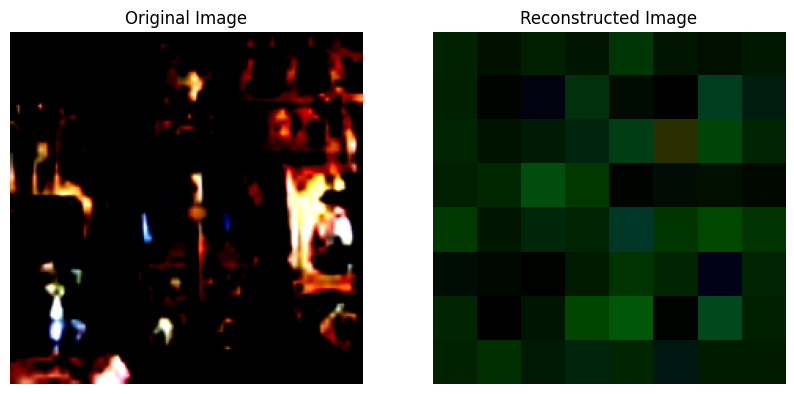

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt

class Deconvolution(nn.Module):
    def __init__(self, input_size):
        super(Deconvolution, self).__init__()
        self.input_size = input_size
        self.deconv_layers = self._make_deconv_layers()

    def _make_deconv_layers(self):
        deconv_layers = nn.Sequential(
            nn.ConvTranspose2d(10, 64, kernel_size=4, stride=2, padding=1),  # inverse of layer5
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.5),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # inverse of layer4
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.5),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)  # inverse of layer3
        )
        return deconv_layers

    def forward(self, x):
        # Move tensors to the specified device
        x = x.to(device)

        # Reshape the input tensor to match the expected dimensions
        batch_size = x.size(0)
        input_size = (batch_size,) + self.input_size
        x = x.view(*input_size)
        out = self.deconv_layers(x)
        return out

# Get the size of the last convolutional layer's output
input_size = (10, 1, 1)  # Assuming each feature map is 1x1

# Instantiate the model
deconv_model = Deconvolution(input_size)
deconv_model.to(device)

# Choose an image from your dataset
sample_image, _ = next(iter(test_dataloader))  # Get a sample image from the test loader
sample_image = sample_image.to(device)

# Forward pass through the model
with torch.no_grad():
    activations = model(sample_image)

# Pass activations through deconvolution layers
reconstructed_image = deconv_model(activations)

# Plot the original and reconstructed image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(sample_image[0].cpu().permute(1, 2, 0))  # Convert to numpy and rearrange dimensions
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Reconstructed Image')
# Detach the reconstructed_image tensor before converting it to a NumPy array
plt.imshow(reconstructed_image[0].detach().cpu().permute(1, 2, 0))  
plt.axis('off')

plt.show()


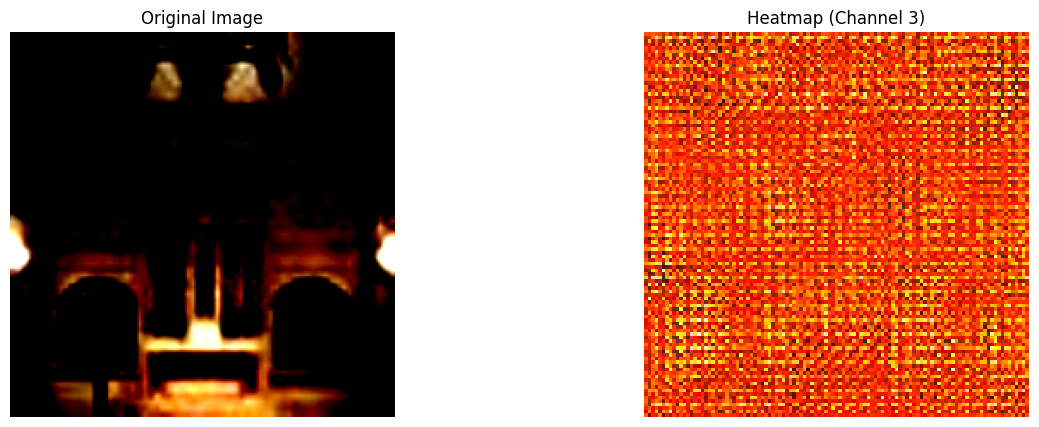

In [15]:
class Visualizer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Visualizer, self).__init__()
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels // 2, out_channels, kernel_size=3, stride=2, padding=1),
            nn.Sigmoid()  
        )
        self.deconv.to(device)

    def forward(self, x):
        return self.deconv(x)



def hook_fn(m, i, o):
    m.activations = o

# Assuming 'layer_id' is the id of the layer whose activations you want to visualize
model.layer1.register_forward_hook(hook_fn)

def visualize_feature_maps(model, image, layer_id):
    model(image)
    activations = model.layer1.activations
    visualizer = Visualizer(activations.size(1), 3) 
    activation = activations.unsqueeze(0) if activations.dim() == 3 else activations
    visualized_maps = visualizer(activation)
    return visualized_maps



for images, _ in test_dataloader:
    image = images[1]  
    break
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
image = image.unsqueeze(0).to(device)  

def plot_heatmap_with_image(heatmap, image, cmap='viridis', alpha=0.6, vmin=None, vmax=None):
    heatmap_numpy = heatmap.cpu().detach().numpy()
    image_numpy = image.squeeze(0).cpu().detach().numpy()
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_numpy.transpose(1, 2, 0))
    plt.title('Original Image')
    plt.axis('off')
    num_channels = heatmap_numpy.shape[1]
    plt.subplot(1, 2, 2)
    for i in range(num_channels):
        heatmap_channel = heatmap_numpy[0, i, :, :]
        plt.imshow(heatmap_channel, cmap=cmap, interpolation='nearest', alpha=alpha, vmin=vmin, vmax=vmax)
        plt.title(f'Heatmap (Channel {i+1})')
        plt.axis('off')

    plt.show()

visualized_feature_maps = visualize_feature_maps(model, image, layer_id=1)
plot_heatmap_with_image(visualized_feature_maps, image, cmap='hot', alpha=0.8, vmin=0.2, vmax=0.8)

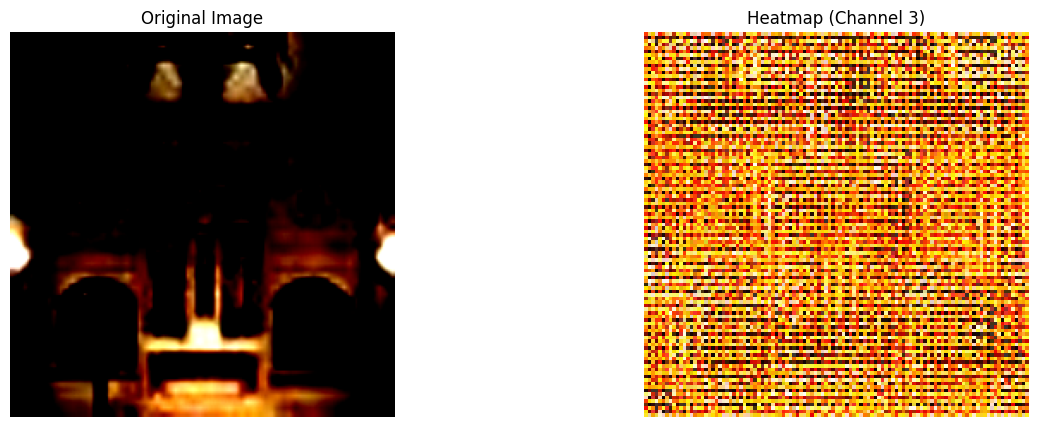

In [16]:
class Visualizer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Visualizer, self).__init__()
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(in_channels // 2),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(in_channels // 2, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.Sigmoid()  
        )
        self.deconv.to(device)

    def forward(self, x):
        return self.deconv(x)

def hook_fn(m, i, o):
    m.activations = o

# Assuming 'layer_id' is the id of the layer whose activations you want to visualize
model.layer1.register_forward_hook(hook_fn)

def visualize_feature_maps(model, image, layer_id):
    model(image)
    activations = model.layer1.activations
    visualizer = Visualizer(activations.size(1), 3) 
    activation = activations.unsqueeze(0) if activations.dim() == 3 else activations
    visualized_maps = visualizer(activation)
    return visualized_maps

for images, _ in test_dataloader:
    image = images[1]  
    break
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
image = image.unsqueeze(0).to(device)  

def plot_heatmap_with_image(heatmap, image, cmap='viridis', alpha=0.6, vmin=None, vmax=None):
    heatmap_numpy = heatmap.cpu().detach().numpy()
    image_numpy = image.squeeze(0).cpu().detach().numpy()
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_numpy.transpose(1, 2, 0))
    plt.title('Original Image')
    plt.axis('off')
    num_channels = heatmap_numpy.shape[1]
    plt.subplot(1, 2, 2)
    for i in range(num_channels):
        heatmap_channel = heatmap_numpy[0, i, :, :]
        plt.imshow(heatmap_channel, cmap=cmap, interpolation='nearest', alpha=alpha, vmin=vmin, vmax=vmax)
        plt.title(f'Heatmap (Channel {i+1})')
        plt.axis('off')

    plt.show()

visualized_feature_maps = visualize_feature_maps(model, image, layer_id=1)
plot_heatmap_with_image(visualized_feature_maps, image, cmap='hot', alpha=0.8, vmin=0.2, vmax=0.8)

TASK3

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_kernels(tensor, num_cols=6):
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

# Assuming 'model' is your PyTorch model
for m in model.modules():
    if isinstance(m, nn.Conv2d):
        # The weights are stored as a torch.Tensor, but we need to convert it to a numpy array
        # The weights are also in the format (out_channels, in_channels, kernel_height, kernel_width), so we need to transpose them to (out_channels, kernel_height, kernel_width, in_channels)
        weight_tensor = m.weight.data.cpu().numpy()
        weight_tensor = np.transpose(weight_tensor, (0, 2, 3, 1))
        plot_kernels(weight_tensor)


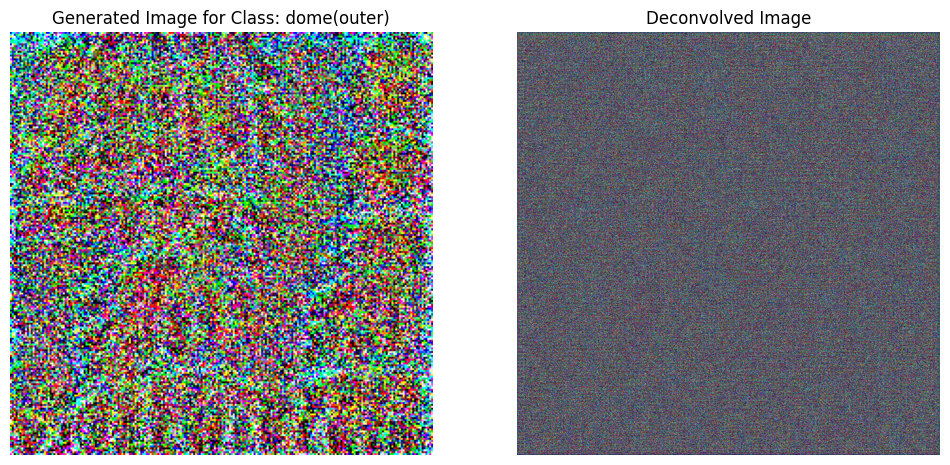

In [20]:
import torch.optim as optim
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class_names = {
    0: "altar",
    1: "apse",
    2: "bell_tower",
    3: "column",
    4: "dome(inner)",
    5: "dome(outer)",
    6: "flying_buttress",
    7: "gargoyle",
    8: "stained_glass",
    9: "vault"
}

def generate_image_for_class(model, target_class, num_steps=1000, lr=0.01, device='cuda'):
    # Initialize a random noise image
    input_image = torch.randn((1, 3, 224, 224), requires_grad=True, device=device)

    # Set the model to evaluation mode
    model.eval()
    model.to(device)

    # Define optimizer
    optimizer = optim.Adam([input_image], lr=lr)

    # Optimization loop
    for _ in range(num_steps):
        optimizer.zero_grad()

        # Forward pass
        output = model(input_image)

        # Calculate loss: maximize activation of the target class
        loss = -output[0, target_class]

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Clip the image values between 0 and 1 after each step
        input_image.data.clamp_(0, 1)

    # Convert the optimized image to numpy array
    generated_image = input_image.detach().cpu().squeeze().numpy().transpose(1, 2, 0)

    return generated_image

def deconvolution(model, generated_image, target_class_index, device='cuda'):
    # Set the model to evaluation mode
    model.eval()

    # Placeholder to store the activation
    activation = None

    # Define a hook to retrieve intermediate activations
    def hook(module, input, output):
        nonlocal activation
        activation = output

    # Register the hook to the last convolutional layer before ReLU
    target_layer = None
    for module in model.modules():
        if isinstance(module, nn.ReLU):
            break
        target_layer = module

    target_layer.register_forward_hook(hook)

    # Forward pass to get the activation of the target class
    input_tensor = torch.tensor(generated_image.transpose(2, 0, 1)).unsqueeze(0)
    input_tensor = input_tensor.to(device)
    output = model(input_tensor)

    # Check if activation is captured
    if activation is None:
        raise ValueError("Activation is None. Ensure that the hook function is properly capturing activations.")

    decoder = nn.Sequential(
        nn.ConvTranspose2d(activation.size(1), 256, kernel_size=4, stride=2, padding=1).to(device),
        nn.ReLU(),
        nn.BatchNorm2d(256).to(device),
        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1).to(device),
        nn.ReLU(),
        nn.BatchNorm2d(128).to(device),
        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1).to(device),
        nn.ReLU(),
        nn.BatchNorm2d(64).to(device),
        nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1).to(device),
        nn.ReLU()  # Apply sigmoid to ensure pixel values are in [0, 1] range
    )

    # Normalize activation maps
    normalized_activation = torch.nn.functional.normalize(activation)

    # Upsample the normalized activation maps using transpose convolutional layers
    reconstructed_image = decoder(normalized_activation)


    # Return the deconvolved image
    return reconstructed_image.detach().cpu().squeeze().numpy().transpose(1, 2, 0)


# Now you can call this deconvolution function in your code
target_class_index = 5  # Change this to the desired class index
generated_image = generate_image_for_class(model, target_class_index)
deconvolved_image = deconvolution(model, generated_image, target_class_index)

# Visualize the generated image and deconvolved image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(generated_image)
plt.title('Generated Image for Class: ' + class_names[target_class_index])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(deconvolved_image)
plt.title('Deconvolved Image')
plt.axis('off')

plt.show()